In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt

dirs = os.listdir('val/')
for dir in dirs:
    if os.path.isdir('val/' + dir):
        files = list(os.listdir('val/' + dir))
        print(dir + ' folder has ' + str(len(files)) + ' images')

base_val_dir = 'val/'
base_train_dir = 'train/'
img_size = 224  
batch = 32

calendula folder has 7 images
bellflower folder has 7 images
iris folder has 7 images
astilbe folder has 7 images
common_daisy folder has 7 images
california_poppy folder has 7 images
carnation folder has 7 images
rose folder has 7 images
tulip folder has 7 images
black_eyed_susan folder has 7 images
coreopsis folder has 7 images
dandelion folder has 7 images
water_lily folder has 7 images
sunflower folder has 7 images


In [23]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_train_dir, 
    seed=123, 
    validation_split=0.2, 
    subset='training', 
    batch_size=batch, 
    image_size=(img_size, img_size)
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_val_dir, 
    seed=123, 
    validation_split=0.2, 
    subset='validation', 
    batch_size=batch, 
    image_size=(img_size, img_size)
)
flower_names = train_ds.class_names
print(flower_names)

Found 13642 files belonging to 14 classes.
Using 10914 files for training.
Found 98 files belonging to 14 classes.
Using 19 files for validation.
['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'dandelion', 'iris', 'rose', 'sunflower', 'tulip', 'water_lily']


2024-05-14 09:44:07.554076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


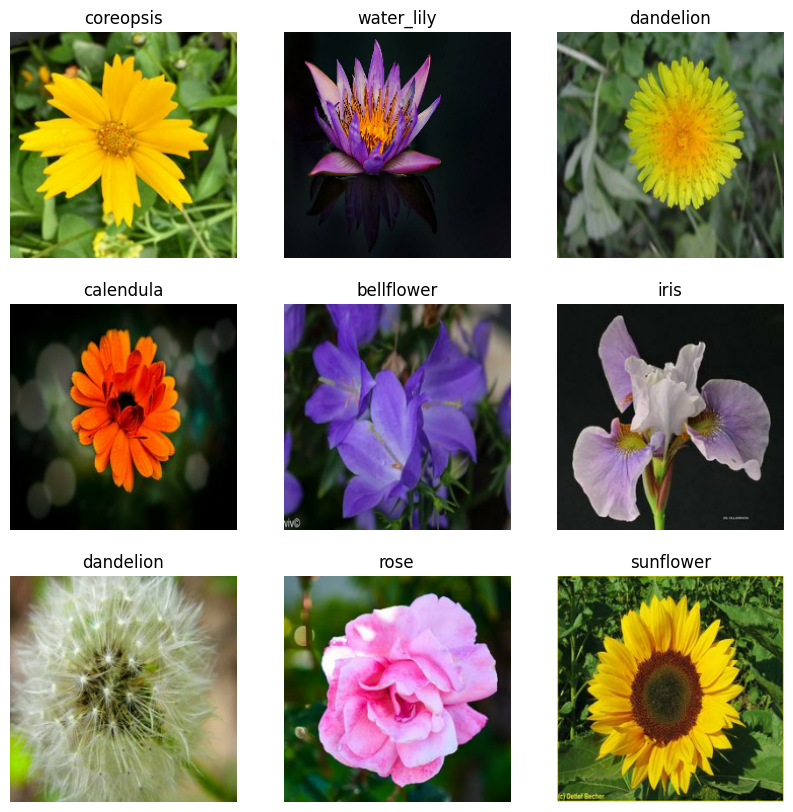

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')
plt.show()

# Data augmentation
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

In [25]:
base_model = EfficientNetB0(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = True

In [19]:
for layer in base_model.layers[:-20]:  # ล็อคเลเยอร์ก่อนหน้าและให้ฝึกได้เฉพาะ 20 เลเยอร์สุดท้าย
    layer.trainable = False

In [28]:
model.build((None, img_size, img_size, 3))
model.summary()

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(flower_names), activation='softmax')  # จำนวนของคลาสตาม dataset
])


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_17 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,215,345 (16.08 MB)

 Trainable params: 4,173,322 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, epochs=15, validation_data=val_ds)
model.save('EfficientNet_Flower_model.h5')


Epoch 1/15
 61/342 ━━━━━━━━━━━━━━━━━━━━ 12:39 3s/step - accuracy: 0.5240 - loss: 1.5464

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model('EfficientNet_Flower_model.h5')

def classify_images(image_path, model, img_size, flower_names):
    input_image = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = np.expand_dims(input_image_array, axis=0)
    
    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)]
    return outcome

result = classify_images('val/black_eyed_susan/2754369825_a06c210f3b_c.jpg', loaded_model, img_size, flower_names)
print(result)